In [7]:
import torch
from torch.utils.data import DataLoader # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt

In [8]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [9]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [10]:
# loading the data
train_dataloader = DataLoader(train_data, batch_size=64) # goes over 938 batches of 64
test_dataloader = DataLoader(test_data, batch_size=64)

Name: T-Shirt, Number: 0


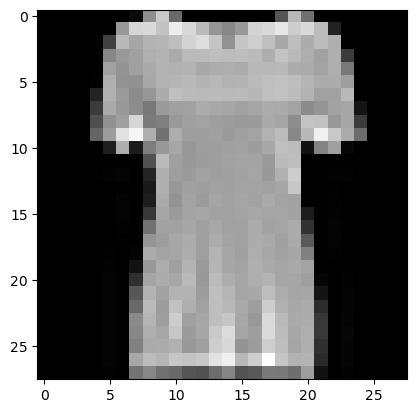

In [11]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [12]:
# flattening the image from 2d to 1d
images = images.view(images.size(0), -1)
print(f"Input (images): {images.shape}\t Output (labels): {labels.shape}")


Input (images): torch.Size([64, 784])	 Output (labels): torch.Size([64])


In [13]:
# implementing MLP

class Neuron:
    # nin is number of inputs
    def __init__(self, nin):
        self.w = torch.rand(nin, requires_grad=True, device="cuda:0")
        self.b = torch.randn(1, requires_grad=True, device="cuda:0")
    
    # x is how many inputs
    def __call__(self, x):
        act = torch.matmul(self.w, x) + self.b  # matrix multiplication with compatible shapes
        out = torch.tanh(act)
        return out # tensor of 1D with 1 value
    
    def parameters(self):
        return [self.w, self.b]
    
class Layer:
    def __init__(self, nin, nout):
        # create nout neurons with nin inputs
        # the amount of neurons is based on how many outputs we need
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons
    
    # x is how many neurons
    def __call__(self, x):
        # x = torch.as_tensor(x).cuda().clone().requires_grad_(True).float()
        # print(x.grad)
        outs = [n(x) for n in self.neurons]
        # print(self.layers[0].parameters())
        return torch.stack(outs)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # nin is number of inputs
    # nouts is the list of number of outputs/neurons per each layer
    def __init__(self, nin, nouts, lr):
        self.lr = lr
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    # bruh this is forward propagation?? weird
    def __call__(self, x):
        # x = torch.as_tensor(x).cuda().clone().detach().requires_grad_(True).float()
        for layer in self.layers:
            x = layer(x) # x is the input from the other neurons
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        with torch.no_grad():
            for param in self.parameters():
                temp = param.data
                param.data -= self.lr * param.grad
                param.grad.zero_()
                # print(temp, param.data)
    
    def zero_grads(self):
        with torch.no_grad():
            for param in self.parameters():
                print(param.grad)
    

In [14]:
random_tensor = torch.randn(3, dtype=torch.float32, device="cuda:0")
labels = torch.randn((2,), dtype=torch.float32, device="cuda:0")

mlp = MLP(3, [4, 4, 2], lr=0.01)


In [15]:
b = mlp.parameters()
a = 0

for i in range(1600):
    ypred = mlp(random_tensor)
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(labels, ypred)])

    loss.backward()

    mlp.update_parameters()

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
    
    a = mlp.parameters()

b == a

Iteration 0, Loss: 0.7171797752380371
Iteration 100, Loss: 0.0038247318007051945
Iteration 200, Loss: 0.0012320593232288957
Iteration 300, Loss: 0.0006614539306610823
Iteration 400, Loss: 0.0004106782143935561
Iteration 500, Loss: 0.00026880373479798436
Iteration 600, Loss: 0.00018082720634993166
Iteration 700, Loss: 0.00012396568490657955
Iteration 800, Loss: 8.625393093097955e-05
Iteration 900, Loss: 6.074551129131578e-05
Iteration 1000, Loss: 4.321054075262509e-05
Iteration 1100, Loss: 3.09927090711426e-05
Iteration 1200, Loss: 2.2382351744454354e-05
Iteration 1300, Loss: 1.6258050891337916e-05
Iteration 1400, Loss: 1.1866680324601475e-05
Iteration 1500, Loss: 8.696529221197125e-06


True

In [16]:
b

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
images, labels = images.to(device), labels.to(device)
labels = labels / 10

In [ ]:
mlp = MLP(nin=784, nouts=[4, 4, 1], lr=0.01)

In [ ]:
# loss = 0
# for i in range(len(labels)):
#     ypred = mlp(images[i])

#     frac_loss = sum((ypred - labels[i]) ** 2)

#     # loss.backward()

#     # mlp.update_parameters()

#     loss += frac_loss
#     print(loss)


before_params = mlp.parameters()
after_params = 0


# for batch, (x, y) in enumerate(train_dataloader):
#     x, y = x.to(device), y.to(device)
#     x_flattened = x.view(x.size(0), -1)
    
#     ypred = [sum(mlp(x_img)) for x_img in x_flattened]
#     loss = sum([(yprd - yact) ** 2 for yprd, yact in zip(ypred, y)])

#     # mlp.zero_grads()

#     loss.backward()

#     mlp.update_parameters()

#     if batch % 100 == 0:
#         print(f"loss: {loss.item()}\t {(batch + 1) * 64}/{len(train_dataloader) * 64}")
    
#     after_params = mlp.parameters()

#     # print(loss)

for i in range(1000):

    ypred = [sum(mlp(img)) for img in images]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(labels, ypred)])

    loss.backward()

    mlp.update_parameters()
    after_params = mlp.parameters()
    print(loss)
    # loss 

before_params == after_params


tensor([2.0221], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0216], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0211], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0206], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0201], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0196], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0190], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0185], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0179], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0174], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0168], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0162], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0156], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0149], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0143], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0137], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0130], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.0123

True

In [ ]:
# for i in range(10000):
#     # Randomly select an index
#     ix = torch.randint(0, 64, (1,)).item()
    
#     # Forward pass through the MLP
#     output = mlp(images[ix]).squeeze()
    
#     # Calculate the loss
#     loss = torch.nn.functional.cross_entropy(output.unsqueeze(0), labels[ix].unsqueeze(0))

#     # Backpropagation
#     loss.backward()

#     # Update parameters
#     mlp.update_parameters()

#     # Print the loss
#     print(f"loss: {loss.item()}")


In [ ]:
# i = 0
# for batch, (x, y) in enumerate(train_dataloader):
#     x = x.view(x.size(0), -1)

#     x, y = x.to(device), y.to(device)

#     for img in x:
#         # img.to(device)
#         # print(img.shape)
#         mlp(img)